In [1]:
import glob
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import seaborn as sn
import statsmodels.formula.api as smf
import xarray as xr
from sqlalchemy.sql import text

plt.style.use("ggplot")

# Compare EMEP change factors

See e-mail from Kari received 28.08.2023 at 14.52.

In [2]:
# Connect to PostGIS
eng = nivapy.da.connect_postgis()

Connection successful.


In [3]:
def calculate_dep_totals(ds):
    """Takes an xarray netCDF dataset in the format used by EMEP and calculates
    grid average deposition totals:

        Total SOx = Wet SOx + Dry SOx
        Total OxN = Wet OxN + Dry OxN
        Total RedN = Wet RedN + Dry RedN
        Total N = Total OxN + Total RedN

    Args:
        ds: xarray dataset

    Returns:
        New variables are added to 'ds'.
    """
    # Pars of interest
    par_list = [
        "DDEP_SOX_m2Grid",
        "WDEP_SOX",
        "DDEP_OXN_m2Grid",
        "WDEP_OXN",
        "DDEP_RDN_m2Grid",
        "WDEP_RDN",
    ]

    # Check N units are consistent
    for par in par_list:
        unit = ds[par].attrs["units"]
        assert unit in ["mgS/m2", "mgN/m2"], "Units not consistent."

    # Calculate total oxidised S
    ds["DEP_SOX"] = ds["WDEP_SOX"] + ds["DDEP_SOX_m2Grid"]
    ds["DEP_SOX"].attrs["units"] = "mgS/m2"

    # Calculate total oxidised N
    ds["DEP_OXN"] = ds["WDEP_OXN"] + ds["DDEP_OXN_m2Grid"]
    ds["DEP_OXN"].attrs["units"] = "mgN/m2"

    # Calculate total reduced N
    ds["DEP_RDN"] = ds["WDEP_RDN"] + ds["DDEP_RDN_m2Grid"]
    ds["DEP_RDN"].attrs["units"] = "mgN/m2"

    # Calculate total N
    ds["DEP_TOTN"] = (
        ds["WDEP_OXN"] + ds["WDEP_RDN"] + ds["DDEP_OXN_m2Grid"] + ds["DDEP_RDN_m2Grid"]
    )
    ds["DEP_TOTN"].attrs["units"] = "mgN/m2"

    return ds

In [4]:
# Get outflows and catchments for 1000 lakes
stn_gdf, cat_gdf = nivapy.da.select_jhub_project_catchments([4], eng)

# Reproject to UTM Zone 33N for accurate distances
stn_gdf = stn_gdf.to_crs("epsg:25833")

stn_gdf.head()

,station_id,station_code,station_name,aquamonitor_id,longitude,latitude,geom
0,259,221-1-2,Langtjern,26070,11.850610,59.809915,POINT (323371.564 6634439.721)
1,260,101-2-7,Hokksjøen,26071,11.559946,59.005125,POINT (302446.090 6545708.790)
2,261,402-2-13,Sætertjern,26072,12.443670,60.057771,POINT (357686.180 6660596.800)
3,262,419-1-25,Mjøgsjøen,26073,11.845276,60.332035,POINT (325847.930 6692557.560)
4,263,425-2-2,Kottern,26074,12.511994,60.587319,POINT (363714.050 6719400.670)


In [5]:
# stn_gdf = stn_gdf.query("station_code == '1228-1-16'")
# stn_gdf

In [6]:
# List files to process
file_paths = [
    f"https://thredds.met.no/thredds/dodsC/data/EMEP/2022_Reporting/EMEP01_rv4.45_year.{year}met_{year}emis_rep2022.nc"
    for year in range(2017, 2020)
]

# Data for 2020 have a different naming convention/url
file_paths += [
    r"https://thredds.met.no/thredds/dodsC/data/EMEP/2022_Reporting/EMEP01_rv4.45_year.2020met_2020emis.nc"
]

In [7]:
# Open datasets
ds = xr.open_mfdataset(
    file_paths,
    combine="by_coords",
)
ds

<xarray.Dataset>
Dimensions:             (lon: 1200, lat: 520, time: 4)
Coordinates:
  * lon                 (lon) float64 -29.95 -29.85 -29.75 ... 89.75 89.85 89.95
  * lat                 (lat) float64 30.05 30.15 30.25 ... 81.75 81.85 81.95
  * time                (time) datetime64[ns] 2017-07-02T12:00:00 ... 2020-07-02
Data variables: (12/49)
    WDEP_PREC           (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    WDEP_SOX            (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    WDEP_OXN            (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    WDEP_RDN            (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    SURF_MAXO3          (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    SURF_PM25water      (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    ...                  ...
    SURF_ug_ECFINE      (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    SURF_ug_ECCOARSE    (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    SURF_ug_PM25        (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    SURF_ug_PM_coarse   (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    SURF_ug_PM25_rh50   (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
    SURF_ug_PM10_rh50   (time, lat, lon) float32 dask.array<chunksize=(1, 520, 1200), meta=np.ndarray>
Attributes:
    vert_coord:                      atmosphere_hybrid_sigma_pressure_coordinate
    Conventions:                     CF-1.6 for coordinates
    model:                           EMEP_MSC-W
    author_of_run:                   emepctm group
    created_date:                    20220923
    created_hour:                    045824.215
    projection:                      lon lat
    period_type:                     fullrun
    run_label:                       rv4_45
    lastmodified_date:               20220924
    lastmodified_hour:               213942.949
    DODS_EXTRA.Unlimited_Dimension:  time

In [8]:
# Load data from URL into memory to improve performance later
ds = ds.load()

In [9]:
# Sum vars in EMEP netCDFs
ds = calculate_dep_totals(ds)

# Get time series for points
par_list = ["DEP_SOX", "DEP_OXN", "DEP_RDN"]
stn_df = stn_gdf.drop("geom", axis="columns")
stn_ds = stn_df.set_index("station_id").to_xarray()
emep_df = (
    ds[par_list]
    .sel(lat=stn_ds["latitude"], lon=stn_ds["longitude"], method="nearest")
    .to_dataframe()
    .reset_index()
)
emep_df["year"] = emep_df["time"].dt.year
emep_df = emep_df[["station_id", "year"] + par_list]
emep_df.rename(
    {
        "DEP_OXN": "n_oks_mgpm2pyr",
        "DEP_RDN": "n_red_mgpm2pyr",
        "DEP_SOX": "s*_mgpm2pyr",
    },
    inplace=True,
    axis="columns",
)

# Average 2017 - 2020
emep_df = emep_df.groupby("station_id").mean().reset_index()

emep_df.head()

,station_id,year,s*_mgpm2pyr,n_oks_mgpm2pyr,n_red_mgpm2pyr
0,259,2018.5,95.956528,299.450806,180.435516
1,260,2018.5,119.037331,364.080872,241.764755
2,261,2018.5,91.153610,266.996155,164.393311
3,262,2018.5,85.894714,268.439514,157.767853
4,263,2018.5,74.210915,215.090729,127.823639


In [10]:
scenario = "Baseline"  # 'Baseline', 'MFR' or 'Diet_low'

df_list = []
for year in [2015, 2030, 2050]:
    fpath = f"/home/jovyan/shared/common/icp_waters/deposition_data/gp_review_scenarios/EMEP01_rv4.45_met2015_emis{year}_{scenario}_v1C_CCE-ICPwaters.nc"
    ds = xr.open_dataset(fpath)
    ds = calculate_dep_totals(ds)
    scen_df = (
        ds[par_list]
        .sel(lat=stn_ds["latitude"], lon=stn_ds["longitude"], method="nearest")
        .to_dataframe()
        .reset_index()
    )
    scen_df["year"] = year
    scen_df = scen_df[["station_id", "year"] + par_list]
    scen_df.rename(
        {
            "DEP_OXN": "n_oks_mgpm2pyr",
            "DEP_RDN": "n_red_mgpm2pyr",
            "DEP_SOX": "s*_mgpm2pyr",
        },
        inplace=True,
        axis="columns",
    )
    df_list.append(scen_df.set_index(["station_id", "year"]))

scen_df = pd.concat(df_list, axis="rows").reset_index()

scen_df

,station_id,year,s*_mgpm2pyr,n_oks_mgpm2pyr,n_red_mgpm2pyr
0,259,2015,126.080643,314.280640,201.196014
1,260,2015,153.377365,387.043701,275.045197
2,261,2015,106.325272,279.951904,182.708801
3,262,2015,102.197937,280.417969,185.981003
4,263,2015,82.842018,222.135056,135.805481
...,...,...,...,...,...
2998,1255,2050,35.927727,65.804115,90.548416
2999,1256,2050,69.055634,118.182007,152.250427
3000,1257,2050,65.039116,108.016327,168.106567
3001,1258,2050,139.024094,60.206154,71.696060


In [11]:
# Append scenarios to NILU historic data
df = pd.concat([emep_df, scen_df], axis="rows")
df = df.melt(id_vars=["station_id", "year"])
df.head()

,station_id,year,variable,value
0,259,2018.5,s*_mgpm2pyr,95.956528
1,260,2018.5,s*_mgpm2pyr,119.037331
2,261,2018.5,s*_mgpm2pyr,91.153610
3,262,2018.5,s*_mgpm2pyr,85.894714
4,263,2018.5,s*_mgpm2pyr,74.210915


/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:3201: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


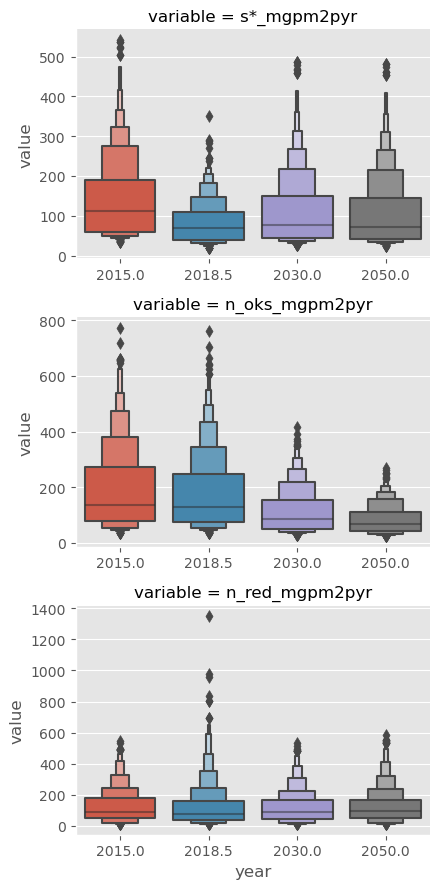

In [12]:
sn.catplot(
    data=df,
    x="year",
    y="value",
    row="variable",
    kind="boxen",
    height=3,
    aspect=1.5,
    sharey=False,
    sharex=False,
)

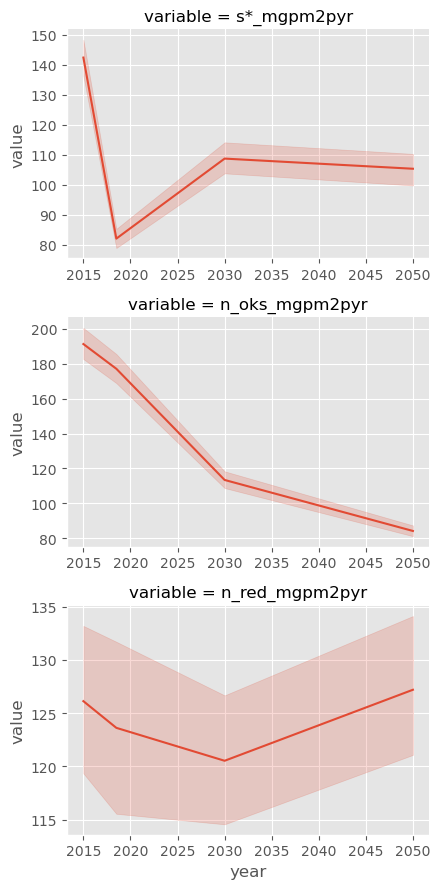

In [13]:
sn.relplot(
    data=df,
    x="year",
    y="value",
    row="variable",
    kind="line",
    height=3,
    aspect=1.5,
    facet_kws={"sharey": False, "sharex": False},
)

In [14]:
base_years = [2015, 2018.5]
fut_years = [2030, 2050]

df_list = []
for base_year in base_years:
    base_df = df.query("year == @base_year").copy()
    del base_df["year"]
    for fut_year in fut_years:
        fut_df = df.query("year == @fut_year").copy()
        del fut_df["year"]
        fac_df = pd.merge(
            base_df,
            fut_df,
            how="left",
            on=["station_id", "variable"],
            suffixes=["_base", "_fut"],
        )
        fac_df["factor"] = fac_df["value_fut"] / fac_df["value_base"]
        del fac_df["value_fut"], fac_df["value_base"]
        fac_df["scenario"] = fut_year
        fac_df["baseline"] = base_year
        df_list.append(fac_df)

fac_df = pd.concat(df_list, axis="rows")
fac_df

,station_id,variable,factor,scenario,baseline
0,259,s*_mgpm2pyr,0.616834,2030,2015.0
1,260,s*_mgpm2pyr,0.594619,2030,2015.0
2,261,s*_mgpm2pyr,0.612276,2030,2015.0
3,262,s*_mgpm2pyr,0.609769,2030,2015.0
4,263,s*_mgpm2pyr,0.621686,2030,2015.0
...,...,...,...,...,...
2998,1255,n_red_mgpm2pyr,1.174747,2050,2018.5
2999,1256,n_red_mgpm2pyr,1.039492,2050,2018.5
3000,1257,n_red_mgpm2pyr,0.937391,2050,2018.5
3001,1258,n_red_mgpm2pyr,1.045578,2050,2018.5


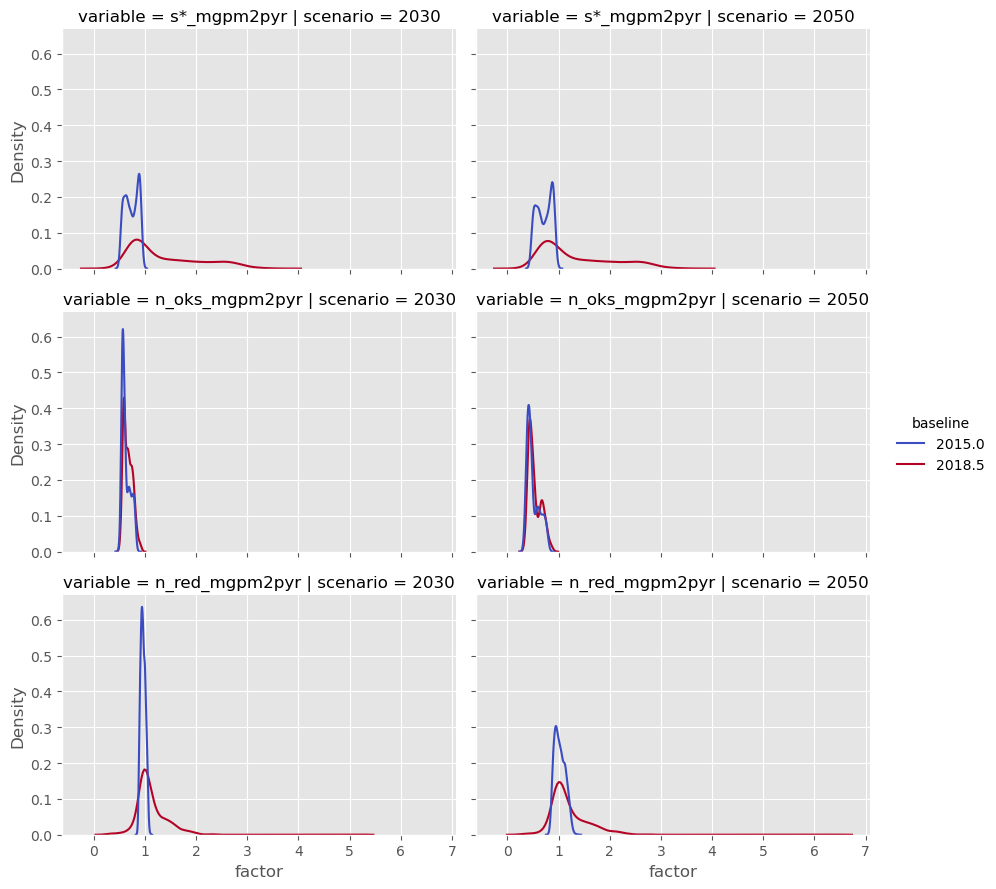

In [15]:
sn.displot(
    data=fac_df,
    col="scenario",
    row="variable",
    x="factor",
    hue="baseline",
    kind="kde",
    palette="coolwarm",
    height=3,
    aspect=1.5,
)